In [1]:
library(magrittr)
library(ggrepel)
library(tidyverse)
library(cowplot)

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')

Loading required package: ggplot2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.1
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Figure 1

In [2]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv('../results/preprocessing/snp2hgnc.tsv', col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv('../results/conventional_gwas/univariate_models.no_covars.tsv', col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1a <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(gene)), 
                    aes(x=BPcum, y=-log10(P), label = gene), size = 5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

In [3]:
gwas <- read_tsv('../results/preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1b <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
                    aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), size = 5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

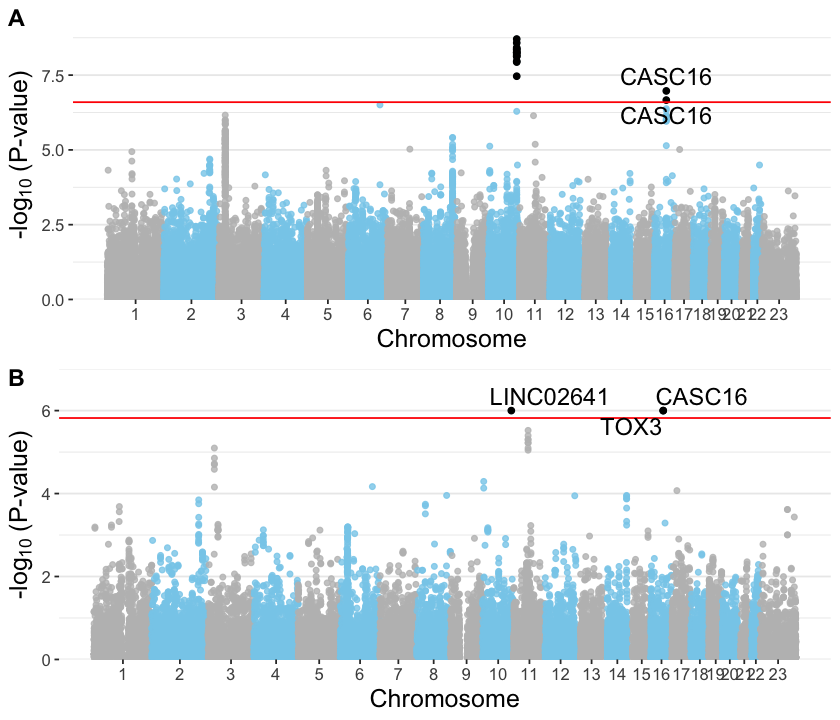

In [4]:
options(repr.plot.width=7, repr.plot.height=6)
f1 <- plot_grid(f1a, f1b, labels = c('A', 'B'), nrow = 2)
f1
ggsave('figures/figure_1.pdf', f1, width=7, height=6)